# Описание данных

Так как требуется научиться сначала сегментировать автомобиль на части, а уже затем находить повреждения, то необходимо иметь 2 датасета:
 - один для сегментации автомобиля
 - второй для сегментации повреждений

## Исследование датасета для сегментации авто на части

### Можно ли сгенерировать синтетические данные или использовать открытые данные для предобучения?

Для решения данной задачи можно использовать открытые данные для предобучения, а также сгенерировать синтетические данные

Тем не менее, в рамках данного проекта было принято решение не использовать синтетические данные. Генерация качественной синтетики требует значительных усилий: необходимо наличие или создание моделей автомобилей, проработка материалов, освещения и рендеринг сцен в фотореалистичном качестве.

Вместо этого выбор был сделан в пользу открытых датасетов, содержащих реальные изображения автомобилей с аннотированными компонентами. Это решение обосновано тем, что в открытом доступе можно найти достаточное количество релевантных и качественно размеченных данных, охватывающих широкий спектр деталей.

In [ ]:
import os
import yaml
from pathlib import Path
from collections import Counter, defaultdict
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import cv2
import random

In [203]:
ROOT_DIR = Path("./car-parts-human-in-the-loop-1")
LABELS_PATH = ROOT_DIR / 'train' / 'labels'
IMAGES_PATH = ROOT_DIR / 'train' / 'images'
DATA_YAML = ROOT_DIR / "data.yaml"
SPLITS = ["train", "val", "test"]

### Примеры изображений
 - Видим, что изображения разных размеров, для обучения модели потребуется привести их к одному размеру  

 - В результате визуального анализа изображений было выявлено, что попадаются как битые автомобили  
 так и не битые, это хорошо, так как, если мы хотим в будущем находить повреждения, то модель сегментации  
 автомобиля на части должна уметь хорошо сегментировать битые автомобили

 - Присутствуют автомобили разных марок, фотографии сделаны при различных погодных условиях  
 и различных условяих освещенности


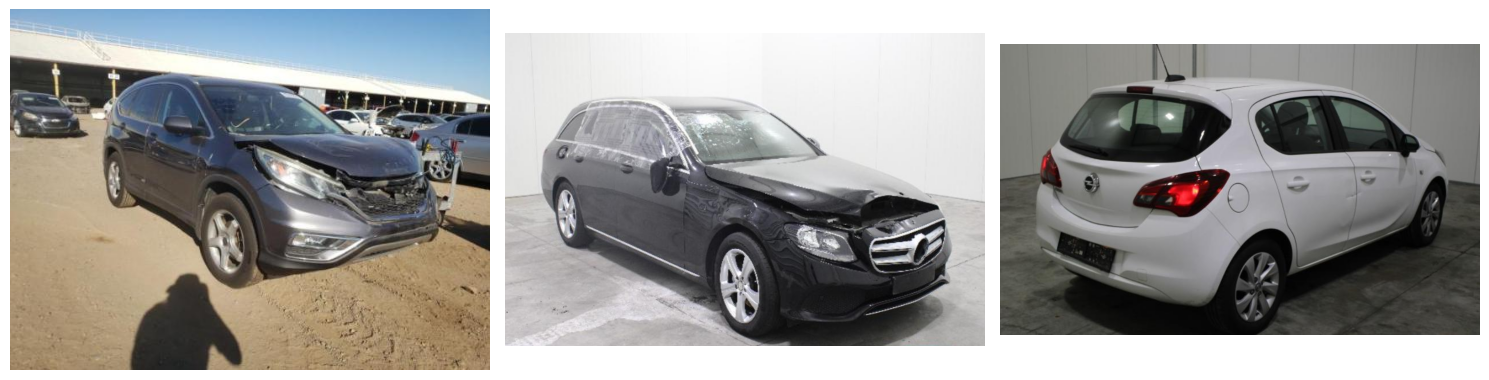

In [ ]:
IMAGE_DIR = Path("./car-parts-human-in-the-loop-1/train/images")

image_paths = list(IMAGE_DIR.glob("*.jpg")) + list(IMAGE_DIR.glob("*.png"))

sample_paths = random.sample(image_paths, min(3, len(image_paths)))

fig, axs = plt.subplots(1, len(sample_paths), figsize=(5 * len(sample_paths), 5))

if len(sample_paths) == 1:
    axs = [axs]

for ax, img_path in zip(axs, sample_paths):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()


### Подсчет количества уникальных классов

Всего 15 уникальных классов, соответствующих основным частям автомобиля

In [9]:
with open(DATA_YAML, "r") as f:
    names = yaml.safe_load(f)["names"]
if isinstance(names, list):
    names = {i: name for i, name in enumerate(names)}

print(f"Всего классов: {len(names)}")
print(f"Список классов: {list(names.values())}")

Всего классов: 15
Список классов: ['Bumper', 'Door', 'Wheel', 'Window', 'Windshield', 'Fender', 'Grille', 'Light', 'Hood', 'License-plate', 'Mirror', 'Quarter-panel', 'Rocker-panel', 'Roof', 'Trunk']


In [6]:
class_counter = Counter()
class_per_split = defaultdict(Counter)
objects_per_image = []
empty_files = []

In [7]:
for split in SPLITS:
    label_dir = ROOT_DIR / split / "labels"
    for label_file in label_dir.glob("*.txt"):
        with open(label_file, "r") as f:
            lines = f.readlines()

        if not lines:
            empty_files.append(label_file)
            continue

        labels = [int(line.split()[0]) for line in lines]
        class_counter.update(labels)
        class_per_split[split].update(labels)
        objects_per_image.append(len(labels))

In [8]:
df_classes = pd.DataFrame({
    "class_id": list(class_counter.keys()),
    "count": list(class_counter.values()),
})
df_classes["class_name"] = df_classes["class_id"].map(names)
df_classes.sort_values("count", ascending=False, inplace=True)

### Анализ распределения объектов по классам
 - По графику виден дисбаланс по классам, однако он не критичный. Наиболее представлен класс Window,  
 а наименее всего класс Licence_plate, к классу Window относятся лобовое и заднее стекла автомобиля, которые  
 видны почти на всех фотографиях, а Licence_plate это номер автомобиля, который сам по себе небольшой  
 и в связи с этим не всегда попадает на изображения

1. Распределение классов по всем аннотациям:
 class_id  count    class_name
        3   2997        Window
        2   2821         Wheel
        7   2652         Light
        1   2612          Door
        0   2546        Bumper
       10   2117        Mirror
        5   2045        Fender
        4   1981    Windshield
       12   1893  Rocker-panel
       11   1868 Quarter-panel
       13   1713          Roof
        8   1538          Hood
        6   1411        Grille
       14   1161         Trunk
        9    945 License-plate


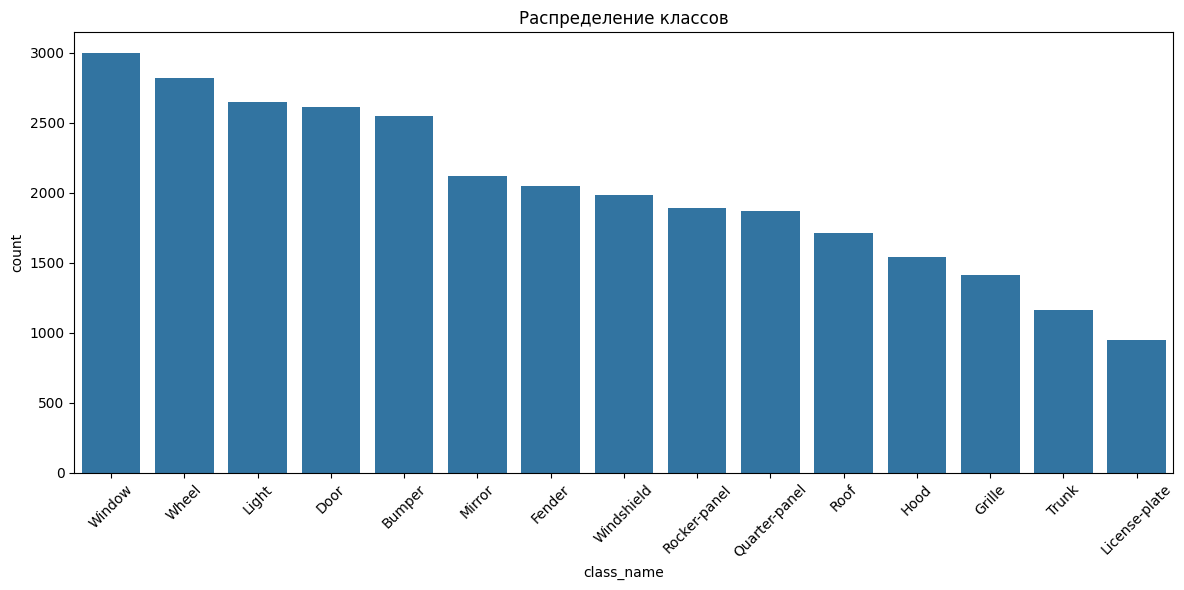

In [ ]:
print("1. Распределение классов по всем аннотациям:")
df_classes = pd.DataFrame({
    "class_id": list(class_counter.keys()),
    "count": list(class_counter.values()),
})
df_classes["class_name"] = df_classes["class_id"].map(names)
df_classes.sort_values("count", ascending=False, inplace=True)
print(df_classes.to_string(index=False))

plt.figure(figsize=(12, 6))
sns.barplot(data=df_classes, x="class_name", y="count")
plt.xticks(rotation=45)
plt.title("Распределение классов")
plt.tight_layout()
plt.show()

### Анализ количества объектов на изображении
 - Исходя из графика мы видим, что на большинстве фотографий от 15 до 20 объектов, что наталкивает на мысль  
 что на большинстве фотографий изображен автомобиль полностью, а не какая-нибудь одиночная его часть
 - Однако есть и изображения с малым количеством объектов, что говорит о том, что встречаются фотографии  
с крупно изображенными частями автомобиля

2. Количество объектов на изображении:
       objects_per_image
count        2206.000000
mean           15.686310
std             4.296015
min             2.000000
25%            14.000000
50%            17.000000
75%            19.000000
max            24.000000


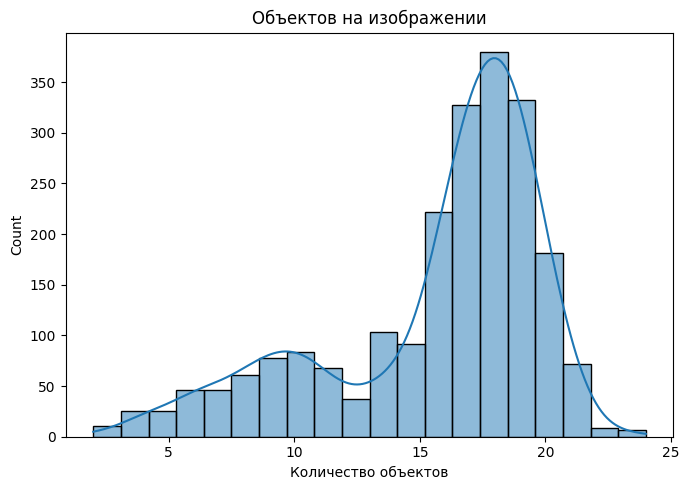

In [162]:
print("2. Количество объектов на изображении:")
df_objects = pd.DataFrame({"objects_per_image": objects_per_image})
print(df_objects.describe())

plt.figure(figsize=(7, 5))
sns.histplot(df_objects["objects_per_image"], bins=20, kde=True)
plt.title("Объектов на изображении")
plt.xlabel("Количество объектов")
plt.tight_layout()
plt.show()

Изображение с максимальным числом объектов:


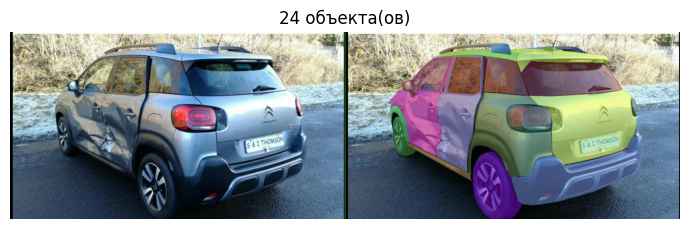

Изображение с минимальным числом объектов:


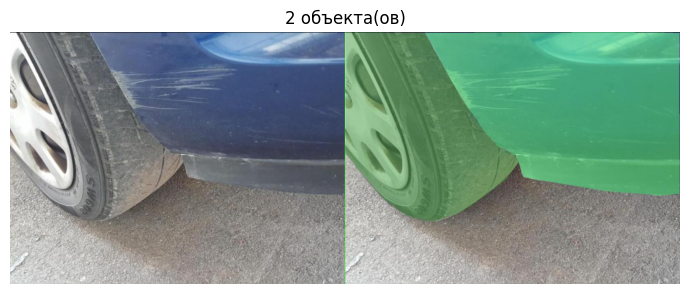

In [206]:
object_counts = {}
for label_file in LABELS_PATH.glob("*.txt"):
    with open(label_file, "r") as f:
        lines = f.readlines()
    stem = label_file.stem
    object_counts[stem] = len(lines)

max_key = max(object_counts, key=object_counts.get)
min_key = min(object_counts, key=object_counts.get)

def show_image_with_boxes(image_name):
    img_path = IMAGES_PATH / f"{image_name}.jpg"
    if not img_path.exists():
        img_path = IMAGES_PATH / f"{image_name}.png"
    label_path = LABELS_PATH / f"{image_name}.txt"

    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.imshow(img)

    with open(label_path, "r") as f:
        for line in f:
            parts = list(map(float, line.strip().split()))
            if len(parts) < 5:
                continue
            _, cx, cy, bw, bh = parts[:5]
            _ = (cx - bw / 2) * w
            _ = (cy - bh / 2) * h
            bw *= w
            bh *= h


    ax.set_title(f"{len(open(label_path).readlines())} объекта(ов)")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

print("Изображение с максимальным числом объектов:")
show_image_with_boxes(max_key)

print("Изображение с минимальным числом объектов:")
show_image_with_boxes(min_key)


Судя по изображениям видно, что в выборке присутствуют как изображения всего автомобиля целиком, так и некоторые части машины отдельно.  
В связи с этим, если автомобиль полностью присутсвует на фотографии, относительный размер одного объекта (части автомобиля) небольшой,  
а если на фотографии изображены только части машины, то площадь объектов будет значительной. Проанализируем относительный размер объектов  
на ихображениях

### Анализ размеров объектов на изображении
 - Из графика видно, что как правило размеры объектов небольшие, в большинстве своем размер объекта не превышает 10% процентов от изображения
 - Минимальый размер объекта почти нулевой, возможно это связано с несовершенством разметки, вряд ли в этом bbox действительно есть объект
 - Максимальный размер объекта около 80% от изображения, скорее всего на таких изображениях показана какая-нибудь одна крупная часть автомобиля
 - Средний размер объектов 14% от изображения

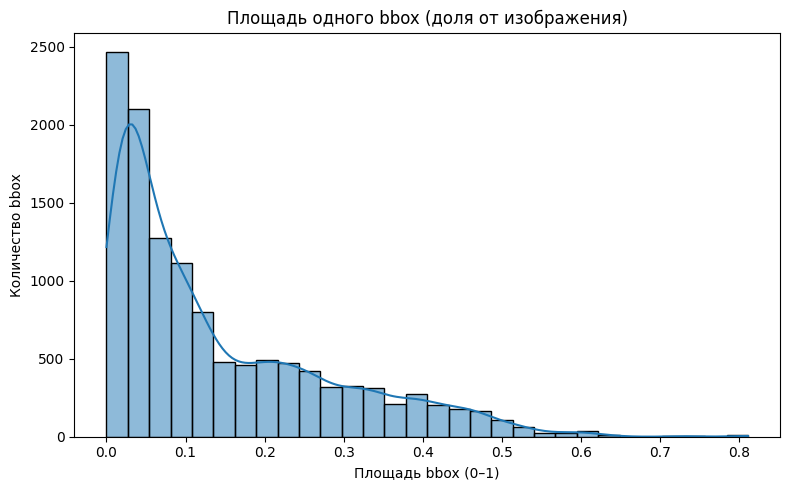

Минимальная относительная площадь bbox: 1.2e-36
Максимальная относительная площадь bbox: 0.811
Средняя относительная площадь bbox: 0.142


In [ ]:
label_files = []
for split in SPLITS:
    label_files.extend(label_dir.glob("*.txt"))

relative_bbox_areas = []
min_area = 1
max_area = 0

for file in label_files:
    with open(file, "r") as f:
        lines = f.readlines()
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5:
            continue
        _, x_center, y_center, w, h = map(float, parts[:5])
        if w <= 0 or h <= 0:
            continue
        area = w * h
        relative_bbox_areas.append(area)
        min_area = min(min_area, area)
        max_area = max(max_area, area)

plt.figure(figsize=(8, 5))
sns.histplot(relative_bbox_areas, bins=30, kde=True)
plt.title("Площадь одного bbox (доля от изображения)")
plt.xlabel("Площадь bbox (0–1)")
plt.ylabel("Количество bbox")
plt.tight_layout()
plt.show()

print(f'Минимальная относительная площадь bbox: {round(min_area, 37)}')
print(f'Максимальная относительная площадь bbox: {round(max_area, 3)}')
print(f'Средняя относительная площадь bbox: {round(np.mean(relative_bbox_areas), 3)}')


### В каком разрешении нужно решать задачу?

Будем обучать модель, используя изображения с разрешением 640х640

 - Во-первых, это стандартное разрешение, используемое в большинстве реализаций моделей YOLO, и оно хорошо сбалансировано между качеством и производительностью. При таком размере входа модель способна сохранять достаточный уровень детализации, чтобы уверенно распознавать как крупные, так и средние по размеру объекты, не перегружая видеопамять и не замедляя обучение.

 - Во-вторых, подавляющее большинство объектов в датасете — такие как окна, колёса, фары, двери — имеют достаточные размеры на изображении, чтобы оставаться различимыми после приведения к 640×640. Они визуально занимают существенную часть кадра. Даже относительно небольшие детали, такие как зеркала или фары, обычно остаются в диапазоне 20–50 пикселей, что является достаточным минимумом для корректного распознавания моделью.

 - В-третьих, размер 640×640 позволяет ускорить обучение и инференс без существенной потери качества. Более высокое разрешение, например 1024×1024, увеличило бы нагрузку на память и время обучения, но дало бы лишь незначительный прирост точности на большинстве классов. Более низкое, например 416×416, могло бы ухудшить распознавание мелких деталей и повлиять на точность.

### Какие аугментации можно использовать?

Аугментации нужно подобрать так, чтобы имитировать разнообразие условий съёмки, компенсировать несбалансированность классов и повысить устойчивость модели к шумам и частичным перекрытиям объектов. Однако при выборе трансформаций нужно учитывать специфику задачи: объекты имеют строгую геометрию, чёткие границы и расположены в реальном физическом пространстве, где не все искажения допустимы.

 1. Подойдут базовые геометрические аугментации, например горизонтальное отражение, поскольку большинство автомобильных компонентов симметричны, и такая трансформация не нарушает логику изображения. Также подойдут небольшие повороты и масштабирование, которые имитируют съёмку с разных ракурсов и расстояний.

 2. Также можно использовать цветовые трансформации — изменение яркости, контраста, насыщенности и оттенков — они помогут обучить модель устойчивости к разным условиям освещения, типам камер и цветам автомобилей.

 3. Можно сделать дополнительное добавление шума, размытия или имитации движения, что позволит сделать модель менее чувствительной к качеству снимка.

**Нельзя делать:**  

 - Нужно избегать тех трансформаций, которые могут исказить структуру объекта. Например, для автомобилей нельзя делать вертикальное отражение, так как это неестественно.





 

## Исследование датасета для сегментации повреждений

### Можно ли сгенерировать синтетические данные или использовать открытые данные для предобучения?

В рамках подготовки данных для обучения модели было принято решение использовать открытые датасеты, содержащие реальные изображения автомобилей с разметкой повреждений. Открытые датасеты содержат различные визуальные условия, включая различные типы дефектов, освещение и ракурсы съёмки. От генерации синтетических данных было решено отказаться, поскольку она требует значительных временных и вычислительных ресурсов, а сами сгенерированные изображения часто не совпадают по визуальному стилю с реальными фото. Кроме того, синтетические повреждения зачастую выглядят ненатурально — имеют чрезмерно правильные формы и маски, что может снижать обобщающую способность модели.

### Примеры изображений из обучающей выборки

В обучающей выборке присутствуют изображения автомобилей с разных ракурсов, имеющих различные повреждения. Повреждения  
могут быть разные по масштабу, один автомобиль может иметь повреждения в нескольких местах

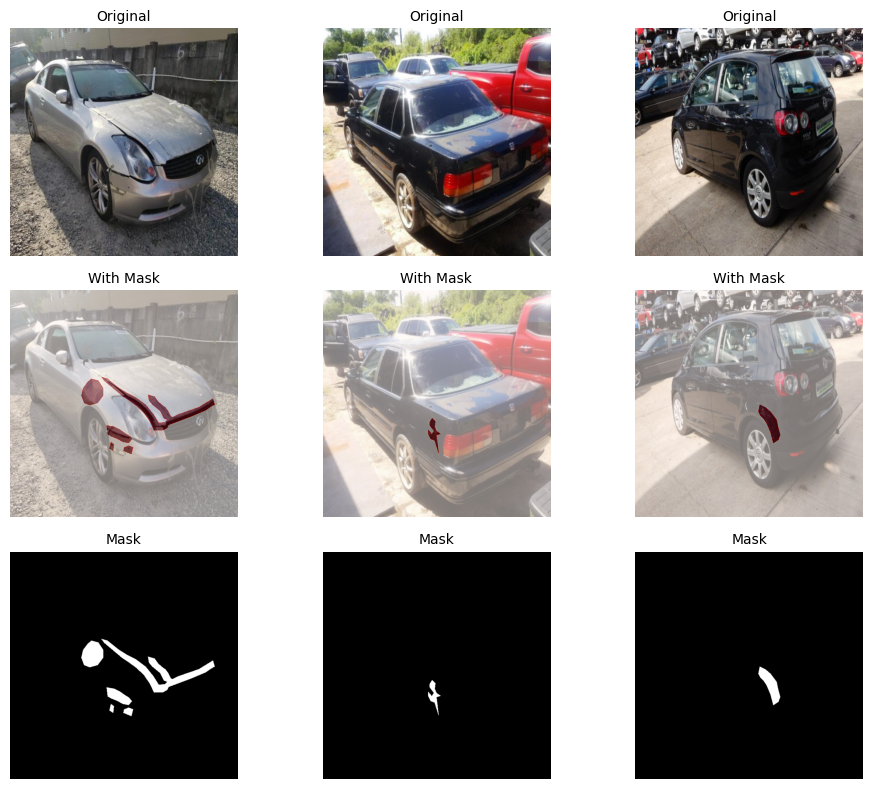

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

image_dir = './car-damage-detection-1/train'
mask_dir = './car-damage-detection-1/train_masks'

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
samples = random.sample(image_files, 3)

plt.figure(figsize=(10, 8))

for i, image_name in enumerate(samples):
    mask_name = image_name.replace('.jpg', '.png')
    image_path = os.path.join(image_dir, image_name)
    mask_path = os.path.join(mask_dir, mask_name)

    image = np.array(Image.open(image_path).convert('RGB'))
    mask = np.array(Image.open(mask_path).convert('L'))
    binary_mask = (mask > 0).astype(np.uint8)

    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title('Original', fontsize=10)
    plt.axis('off')

    plt.subplot(3, 3, i + 4)
    plt.imshow(image)
    plt.imshow(binary_mask, alpha=0.5, cmap='Reds')
    plt.title('With Mask', fontsize=10)
    plt.axis('off')

    plt.subplot(3, 3, i + 7)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


### Анализ размеров изображений

In [150]:
def get_image_sizes(folder):
    sizes = []
    for fname in os.listdir(folder):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        path = os.path.join(folder, fname)
        img = Image.open(path)
        sizes.append(img.size)
    return Counter(sizes)

base_path = './car-damage-detection-1'
splits = ['train', 'valid', 'test']

for split in splits:
    image_folder = os.path.join(base_path, split)
    size_counts = get_image_sizes(image_folder)
    print(f'\n{split.upper()} — размеры изображений:')
    for size, count in size_counts.items():
        print(f'  {size[0]}x{size[1]} — {count} изображений')



TRAIN — размеры изображений:
  640x640 — 1599 изображений

VALID — размеры изображений:
  640x640 — 452 изображений

TEST — размеры изображений:
  640x640 — 225 изображений


Все изображения имеют размер 640х640, то есть они уже приведены к одному масштабу

### Анализ площади повреждений в обучающей, валидационной и тестовой выборках

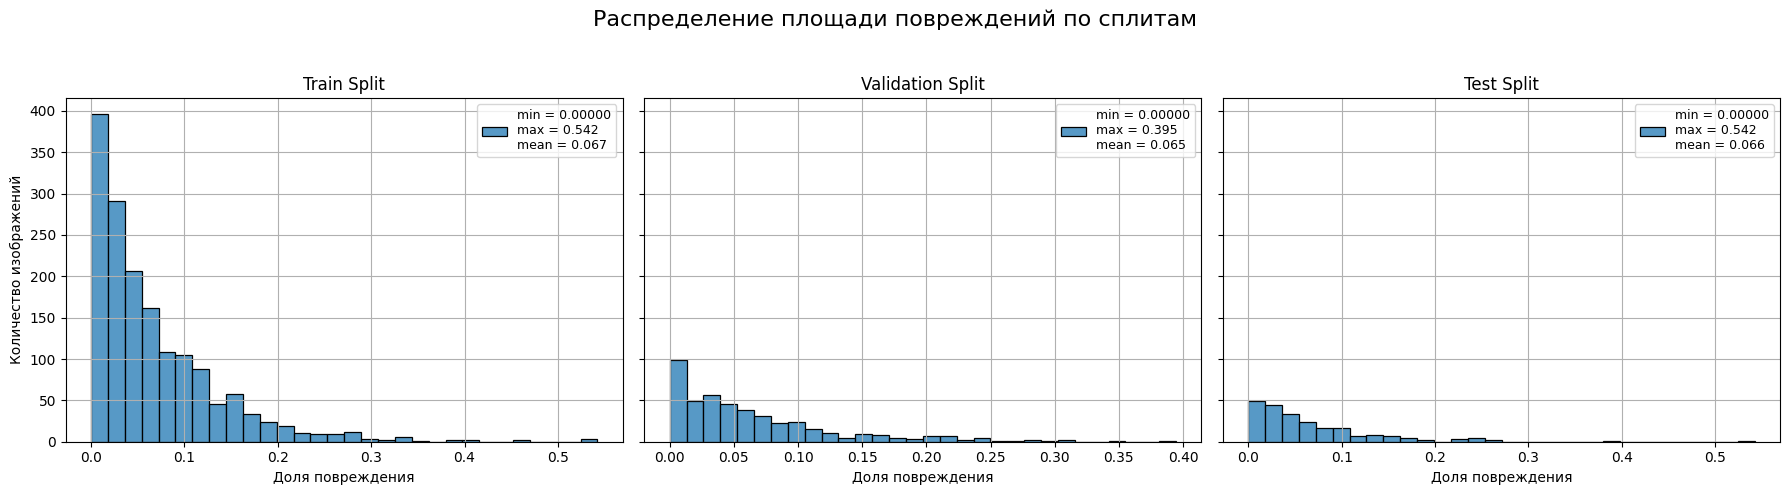

In [ ]:
def calculate_mask_coverage(mask_folder):
    coverages = []
    for mask_name in os.listdir(mask_folder):
        if not mask_name.endswith('.png'):
            continue
        mask_path = os.path.join(mask_folder, mask_name)
        mask = np.array(Image.open(mask_path).convert('L'))
        coverage = np.sum(mask > 0) / mask.size
        coverages.append(coverage)
    return coverages

base_path = './car-damage-detection-1'
splits = {
    'Train': os.path.join(base_path, 'train_masks'),
    'Validation': os.path.join(base_path, 'valid_masks'),
    'Test': os.path.join(base_path, 'test_masks')
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (split_name, mask_dir) in zip(axes, splits.items()):
    coverages = calculate_mask_coverage(mask_dir)
    min_val = min(coverages)
    max_val = max(coverages)
    mean_val = np.mean(coverages)

    sns.histplot(coverages, bins=30, kde=False, ax=ax)
    ax.set_title(f'{split_name} Split')
    ax.set_xlabel('Доля повреждения')
    ax.set_ylabel('Количество изображений')
    ax.grid(True)

    stats_text = f'min = {min_val:.5f}\nmax = {max_val:.3f}\nmean = {mean_val:.3f}'
    ax.legend([stats_text], loc='upper right', fontsize=9)

plt.suptitle('Распределение площади повреждений по сплитам', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


По приведенным графикам видно, что распределение площадей повреждений в выборках примерно одинаковое, присутствуют как крупные,  
занимающие около половины всего изображения, повреждения, так и мелкие, занимающие несколько процентов от площади изображения.
 - Минимальный размер повреждения равен нулю, что говорит о том, что в выборках встречаются автомобили без повреждений
 - Максимальный размер повреждения около 54% от изображения, следовательно встречаются фотографии автомобилей с большими повреждениями
 - Средний рахмер повреджения примерно 6.5% от площади изображения

### Детальный анализ повреждений в каждой из выборок

test_masks: 100%|██████████| 225/225 [00:00<00:00, 440.34it/s]


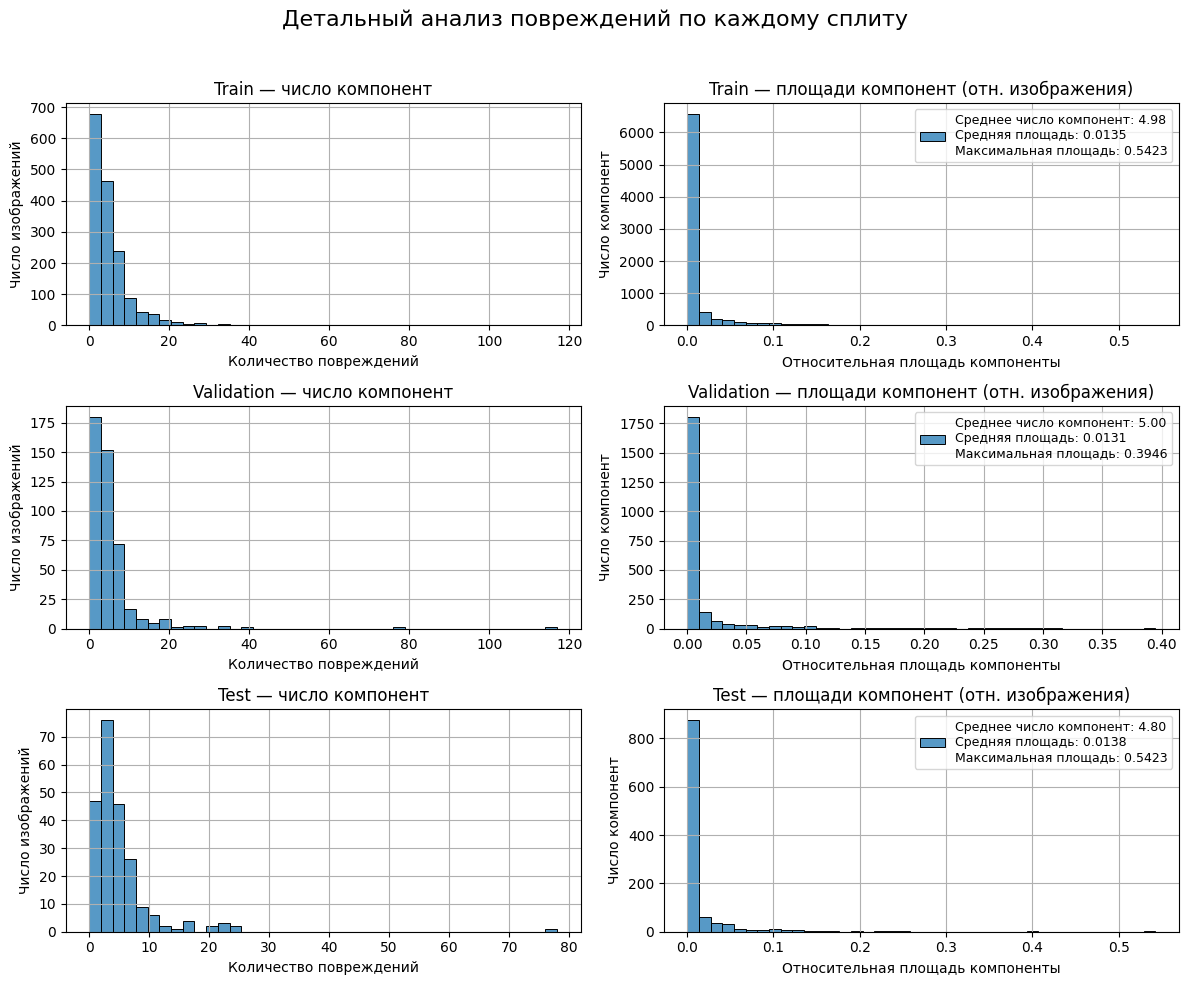

In [160]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import label
from tqdm import tqdm

def analyze_connected_components(mask_dir):
    component_counts = []
    component_areas = []

    for fname in tqdm(os.listdir(mask_dir), desc=os.path.basename(mask_dir)):
        if not fname.endswith('.png'):
            continue
        mask_path = os.path.join(mask_dir, fname)
        mask = np.array(Image.open(mask_path).convert('L'))
        binary_mask = (mask > 0).astype(np.uint8)
        img_area = binary_mask.shape[0] * binary_mask.shape[1]

        labeled_mask, num_features = label(binary_mask)
        component_counts.append(num_features)

        for i in range(1, num_features + 1):
            area = np.sum(labeled_mask == i) / img_area
            component_areas.append(area)

    return component_counts, component_areas

base_path = './car-damage-detection-1'
splits = {
    'Train': os.path.join(base_path, 'train_masks'),
    'Validation': os.path.join(base_path, 'valid_masks'),
    'Test': os.path.join(base_path, 'test_masks')
}

fig, axes = plt.subplots(len(splits), 2, figsize=(12, 10))
fig.suptitle('Детальный анализ повреждений по каждому сплиту', fontsize=16)

for row_idx, (split_name, mask_dir) in enumerate(splits.items()):
    comp_counts, comp_areas = analyze_connected_components(mask_dir)

    ax1 = axes[row_idx, 0]
    sns.histplot(comp_counts, bins=40, ax=ax1, kde=False)
    ax1.set_title(f'{split_name} — число компонент')
    ax1.set_xlabel('Количество повреждений')
    ax1.set_ylabel('Число изображений')
    ax1.grid(True)

    ax2 = axes[row_idx, 1]
    sns.histplot(comp_areas, bins=40, ax=ax2, kde=False)
    ax2.set_title(f'{split_name} — площади компонент (отн. изображения)')
    ax2.set_xlabel('Относительная площадь компоненты')
    ax2.set_ylabel('Число компонент')
    ax2.grid(True)

    legend_text = (
        f'Среднее число компонент: {np.mean(comp_counts):.2f}\n'
        f'Средняя площадь: {np.mean(comp_areas):.4f}\n'
        f'Максимальная площадь: {np.max(comp_areas):.4f}'
    )
    ax2.legend([legend_text], loc='upper right', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Исходя из графиков делаем вывод, что в среднем автомобиль имеет 5 компонент повреждений, при этом, как уже говорилось, втречаются и крупные и мелкие компоненты
 - Максимальная площадь одной компоненты около 54% площади изображения
 - Средняя площадь около 1.4% от изображения

Посмотрим на примеры автомобилей с крупными и мелкими повреждениями, а также на автомобили, имеющие более 20 компонент повреждений

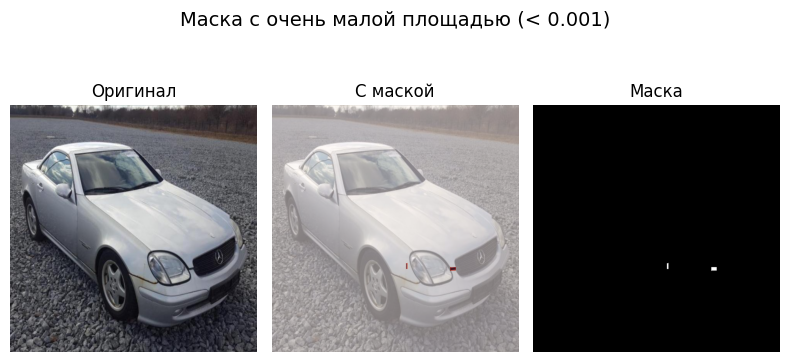

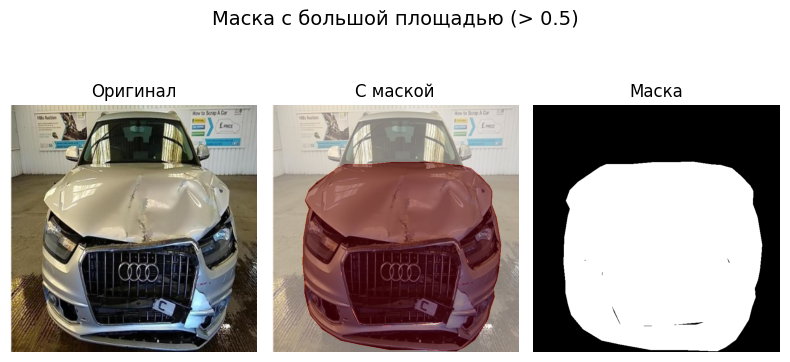

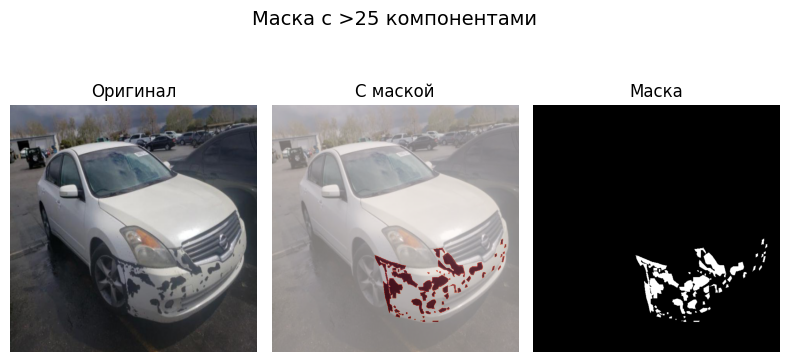

In [194]:
base_path = './car-damage-detection-1'
image_dir = os.path.join(base_path, 'train')
mask_dir = os.path.join(base_path, 'train_masks')

MIN_THRESHOLD = 0.0005
MAX_THRESHOLD = 0.5
COMPONENT_THRESHOLD = 25

small_area_files = []
large_area_files = []
many_components_files = []

for fname in os.listdir(mask_dir):
    if not fname.endswith('.png'):
        continue

    mask_path = os.path.join(mask_dir, fname)
    image_path = os.path.join(image_dir, fname.replace('.png', '.jpg'))

    mask = np.array(Image.open(mask_path).convert('L'))
    binary_mask = (mask > 0).astype(np.uint8)
    total_area = binary_mask.size
    mask_area = np.sum(binary_mask) / total_area

    labeled_mask, num_components = label(binary_mask)

    if mask_area < MIN_THRESHOLD and mask_area > 0:
        small_area_files.append((image_path, mask_path))
    if mask_area > MAX_THRESHOLD:
        large_area_files.append((image_path, mask_path))
    if num_components > COMPONENT_THRESHOLD:
        many_components_files.append((image_path, mask_path))

random.seed(42)
small_area_example = random.choice(small_area_files) if small_area_files else None
large_area_example = random.choice(large_area_files) if large_area_files else None
many_components_example = random.choice(many_components_files) if many_components_files else None

def show_single_example(img_path, msk_path, title):
    image = np.array(Image.open(img_path).convert('RGB'))
    mask = np.array(Image.open(msk_path).convert('L'))
    binary_mask = (mask > 0).astype(np.uint8)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Оригинал')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(binary_mask, alpha=0.5, cmap='Reds')
    plt.title('С маской')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title('Маска')
    plt.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

if small_area_example:
    show_single_example(*small_area_example, 'Маска с очень малой площадью (< 0.001)')
if large_area_example:
    show_single_example(*large_area_example, 'Маска с большой площадью (> 0.5)')
if many_components_example:
    show_single_example(*many_components_example, 'Маска с >25 компонентами')


### В каком разрешении нужно решать задачу?
В данном случае разрешение изображений играет важную роль, так как речь идёт о небольших дефектах, таких как царапины или вмятины. Оптимальными являются размеры 512×512 или 640×640 пикселей, обеспечивающие баланс между сохранением деталей и вычислительной эффективностью. Поскольку в используемом датасете изображения уже приведены к формату 640×640, этот размер и будет использоваться при обучении модели.


### Какие аугментации можно использовать?
Можно использовать разнообразные аугментации, направленные на повышение устойчивости модели к изменениям в освещении, ракурсе и качестве изображения. Подойдут следующие трансформации:
 - `HorizontalFlip` — для отражения симметричных случаев
 - `ShiftScaleRotate` — для моделирования сдвигов, масштабирования и поворотов
 - `RandomCrop` — для стандартизации входных изображений и повышения обобщающей способности

Из фотометрических аугментаций можно применить:

 - `BrightnessContrast`, `HueSaturationValue`, `GaussianNoise` и `Blur` -  имитируют реальные искажения при съёмке

**Нельзя использовать аугментации, разрушающие структуру или теряющие точность маски:**

 - `Cutout`, `GridMask` и  `RandomErasing`, так как они могут случайно искажать или удалять мелкие повреждения, что приведёт к ухудшению качества разметки и обучению модели на искажённых примерах.
